In [14]:
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) =boston_housing.load_data()

See, you have 404 training samples and 102 test samples, each with 13
numerical features, such as per capita crime rate, average number of rooms per dwelling,
accessibility to highways, and so on.
The targets are the median values of owner-occupied homes, in thousands of
dollars:

In [15]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

Do feature-wise normalization: for each feature in the input
data (a column in the input data matrix), you subtract the mean of the feature and
divide by the standard deviation, so that the feature is centered around 0 and has a
unit standard deviation. This is easily done in Numpy.


Note that the quantities used for normalizing the test data are computed using the
training data. You should never use in your workflow any quantity computed on the
test data, even for something as simple as data normalization.

In [16]:
from keras import models
from keras import layers
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

The network ends with a single unit and no activation (it will be a linear layer). This is
a typical setup for scalar regression (a regression where you’re trying to predict a single
continuous value). Applying an activation function would constrain the range the output
can take; for instance, if you applied a sigmoid activation function to the last layer,
the network could only learn to predict values between 0 and 1. Here, because the last
layer is purely linear, the network is free to learn to predict values in any range.

Note that you compile the network with the mse loss function—mean squared error,
the square of the difference between the predictions and the targets. This is a widely
used loss function for regression problems.
You’re also monitoring a new metric during training: mean absolute error (MAE). It’s
the absolute value of the difference between the predictions and the targets. For
instance, an MAE of 0.5 on this problem would mean your predictions are off by $500
on average.

In [21]:
import numpy as np
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []


for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

partial_train_data = np.concatenate([train_data[:i * num_val_samples],train_data[(i + 1) * num_val_samples:]],axis=0)
partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],train_targets[(i + 1) * num_val_samples:]],axis=0)



processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


We have so few data points,
the validation set would end up being very small (for instance, about 100 examples).
As a consequence, the validation scores might change a lot depending on which data
points you chose to use for validation and which you chose for training: the validation
scores might have a high variance with regard to the validation split. This would prevent
you from reliably evaluating your model.
The best practice in such situations is to use K-fold cross-validation (see figure 3.11).
It consists of splitting the available data into K partitions (typically K = 4 or 5), instantiating
K identical models, and training each one on K – 1 partitions while evaluating on
the remaining partition. The validation score for the model used is then the average of
the K validation scores obtained.

In [22]:
model = build_model()

model.fit(partial_train_data, partial_train_targets,epochs=num_epochs, batch_size=1, verbose=0)

val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
all_scores.append(val_mae)

print(all_scores)
print(np.mean(all_scores))

[2.5277884006500244]
2.5277884006500244


The different runs do indeed show rather different validation scores, from 2.6 to 3.2.
The average (3.0) is a much more reliable metric than any single score—that’s the
entire point of K-fold cross-validation. In this case, you’re off by $3,000 on average,which is significant considering that the prices range from $10,000 to $50,000.
Let’s try training the network a bit longer: 500 epochs. To keep a record of how
well the model does at each epoch, you’ll modify the training loop to save the perepoch
validation score log.

In [23]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
partial_train_data = np.concatenate([train_data[:i * num_val_samples],train_data[(i + 1) * num_val_samples:]],axis=0)
partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],train_targets[(i + 1) * num_val_samples:]],axis=0)

model = build_model()
history = model.fit(partial_train_data, partial_train_targets,validation_data=(val_data, val_targets),epochs=num_epochs, batch_size=1, verbose=0)
mae_history = history.history['val_mae']
all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [24]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

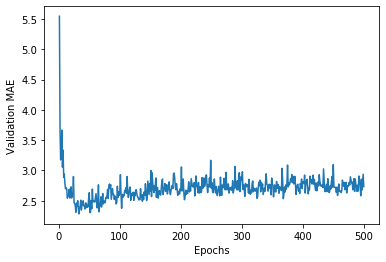

In [29]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

It may be a little difficult to see the plot, due to scaling issues and relatively high variance.
Let’s do the following:
 Omit the first 10 data points, which are on a different scale than the rest of the curve.
 Replace each point with an exponential moving average of the previous points,
to obtain a smooth curve.

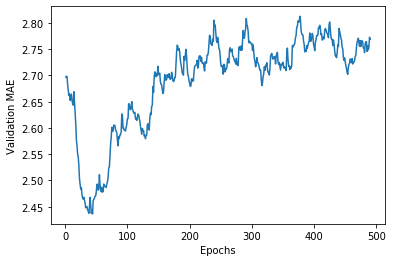

In [27]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points
smooth_mae_history = smooth_curve(average_mae_history[10:])
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

According to this plot, validation MAE stops improving significantly after 80 epochs.
Past that point, you start overfitting.
Once you’re finished tuning other parameters of the model (in addition to the
number of epochs, you could also adjust the size of the hidden layers), you can train a
final production model on all of the training data, with the best parameters, and then
look at its performance on the test data.

In [28]:
model = build_model()
model.fit(train_data, train_targets,epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 100us/step


In [30]:
test_mae_score

2.57047176361084